# Random Forest on Glass Dataset — Assignment Notebook

**Dataset path (local):** `D:\DATA-SCIENCE\ASSIGNMENTS\14 random forest\glass.xlsx`

**Objective:** Perform EDA, preprocessing, build Random Forest model, compare Bagging and Boosting methods, and discuss handling imbalance. This notebook includes markdown explanations and runnable code for each task.

---

## 1) Data Loading
Load the Glass dataset and inspect its structure.

In [8]:
# 1) Data Loading
import os, pandas as pd, numpy as np
DATA_DIR = r"D:\DATA-SCIENCE\ASSIGNMENTS\14 random forest"
file_path = os.path.join(DATA_DIR, "glass.xlsx")

# Fallback to sandbox if running here
if not os.path.exists(file_path):
    file_path = "/mnt/data/glass.xlsx"

print("Loading dataset from:", file_path)
df = pd.read_excel(file_path)
print("Shape:", df.shape)
display(df.head())

Loading dataset from: D:\DATA-SCIENCE\ASSIGNMENTS\14 random forest\glass.xlsx
Shape: (214, 10)


RI     Na    Mg    Al     Si     K    Ca   Ba   Fe  Type
0  1.52101  13.64  4.49  1.10  71.78  0.06  8.75  0.0  0.0     1
1  1.51761  13.89  3.60  1.36  72.73  0.48  7.83  0.0  0.0     1
2  1.51618  13.53  3.55  1.54  72.99  0.39  7.78  0.0  0.0     1
3  1.51766  13.21  3.69  1.29  72.61  0.57  8.22  0.0  0.0     1
4  1.51742  13.27  3.62  1.24  73.08  0.55  8.07  0.0  0.0     1

## 2) Exploratory Data Analysis (EDA)
Check data types, missing values, descriptive stats, and basic value distributions.

In [9]:
# 2) EDA
import matplotlib.pyplot as plt, seaborn as sns
sns.set(style="whitegrid")

print("Data types:\n")
display(df.dtypes.to_frame('dtype'))

print("\nMissing values per column:\n")
display(df.isnull().sum().to_frame('missing_count'))

print("\nDescriptive statistics:\n")
display(df.describe().T)

# Check class distribution if target exists (common name: 'Type' or last column)
possible_targets = [c for c in df.columns if c.lower() in ['type','glass_type','target','class','label']]
if len(possible_targets)==0:
    target_col = df.columns[-1]
else:
    target_col = possible_targets[0]
print("\nDetected target column:", target_col)
display(df[target_col].value_counts())

Data types:



dtype
RI    float64
Na    float64
Mg    float64
Al    float64
Si    float64
K     float64
Ca    float64
Ba    float64
Fe    float64
Type    int64


Missing values per column:



missing_count
RI                0
Na                0
Mg                0
Al                0
Si                0
K                 0
Ca                0
Ba                0
Fe                0
Type              0


Descriptive statistics:



count       mean       std       min        25%       50%        75%  \
RI    214.0   1.518365  0.003037   1.51115   1.516522   1.51768   1.519157   
Na    214.0  13.407850  0.816604  10.73000  12.907500  13.30000  13.825000   
Mg    214.0   2.684533  1.442408   0.00000   2.115000   3.48000   3.600000   
Al    214.0   1.444907  0.499270   0.29000   1.190000   1.36000   1.630000   
Si    214.0  72.650935  0.774546  69.81000  72.280000  72.79000  73.087500   
K     214.0   0.497056  0.652192   0.00000   0.122500   0.55500   0.610000   
Ca    214.0   8.956963  1.423153   5.43000   8.240000   8.60000   9.172500   
Ba    214.0   0.175047  0.497219   0.00000   0.000000   0.00000   0.000000   
Fe    214.0   0.057009  0.097439   0.00000   0.000000   0.00000   0.100000   
Type  214.0   2.780374  2.103739   1.00000   1.000000   2.00000   3.000000   

           max  
RI     1.53393  
Na    17.38000  
Mg     4.49000  
Al     3.50000  
Si    75.41000  
K      6.21000  
Ca    16.19000  
Ba     3.15000  
Fe     0.51000  
Type   7.00000


Detected target column: Type


Type
2    76
1    70
7    29
3    17
5    13
6     9
Name: count, dtype: int64

## 3) Data Visualization
Plot histograms, boxplots, pairplot (sample), and correlation heatmap to understand relationships.

### 3) Visualization (robust)
Visualize numeric feature distributions (histograms + boxplots).  
Only draw correlation heatmap and pairplot if we have enough numeric features. Pairplot is sampled to keep runtime reasonable.


In [10]:
print(df.dtypes)
print("num_cols initially:", df.select_dtypes(include=['number']).columns.tolist())
print("all columns:", df.columns.tolist())


RI      float64
Na      float64
Mg      float64
Al      float64
Si      float64
K       float64
Ca      float64
Ba      float64
Fe      float64
Type      int64
dtype: object
num_cols initially: ['RI', 'Na', 'Mg', 'Al', 'Si', 'K', 'Ca', 'Ba', 'Fe', 'Type']
all columns: ['RI', 'Na', 'Mg', 'Al', 'Si', 'K', 'Ca', 'Ba', 'Fe', 'Type']


Numeric columns used for visualization (9): ['RI', 'Na', 'Mg', 'Al', 'Si', 'K', 'Ca', 'Ba', 'Fe']


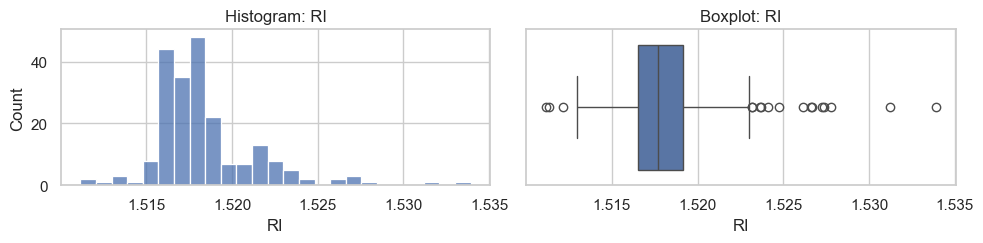

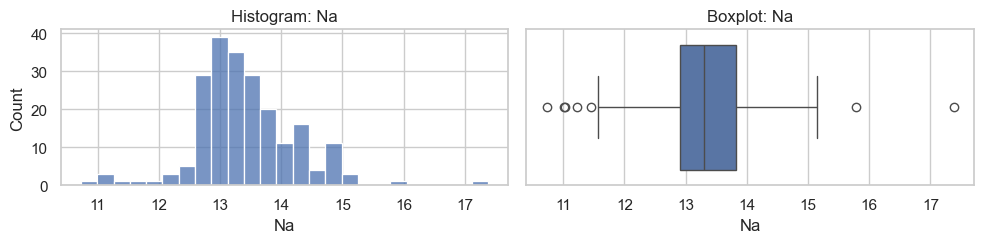

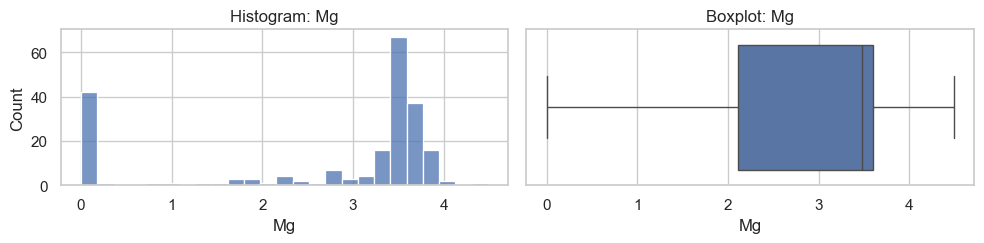

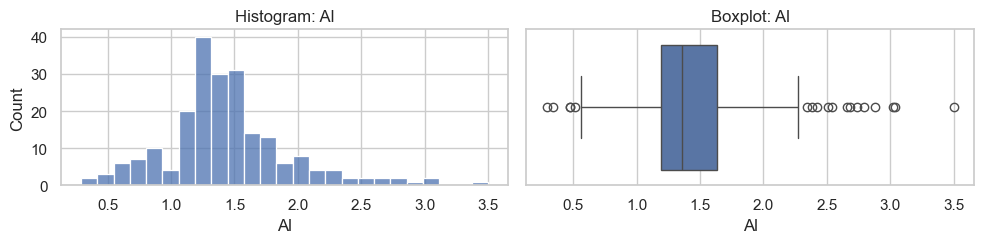

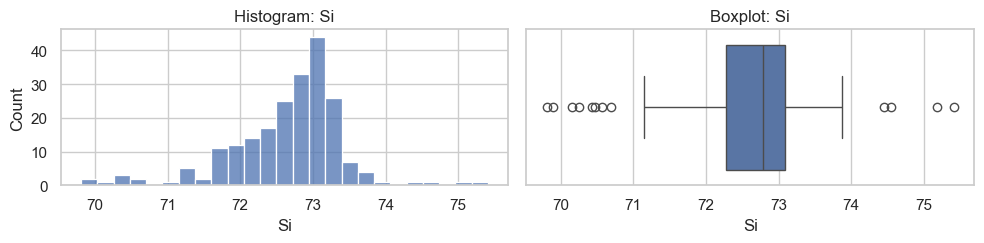

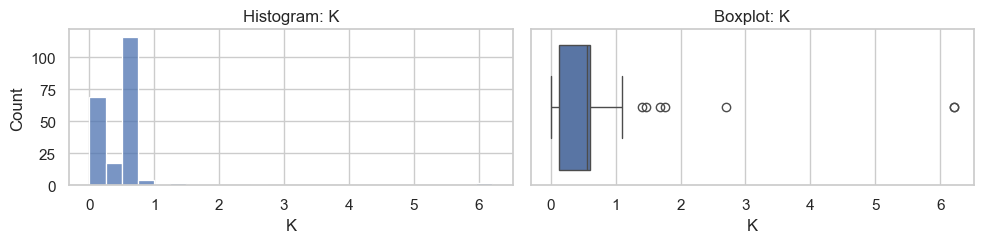

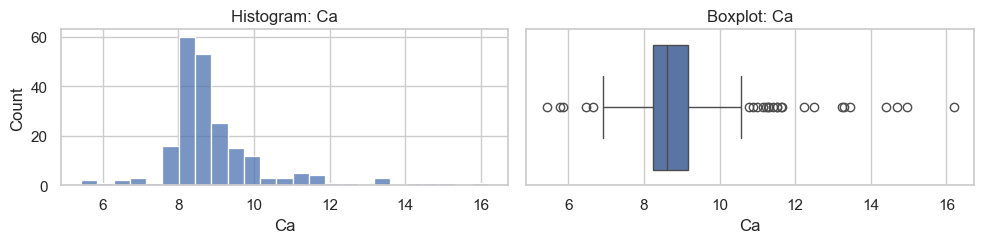

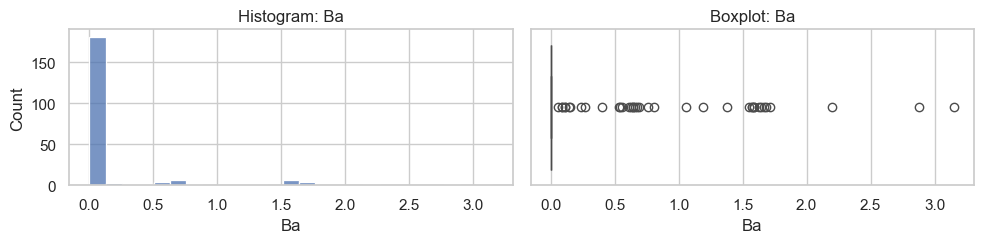

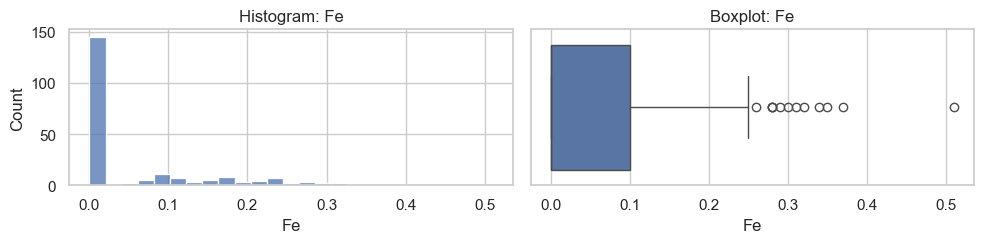

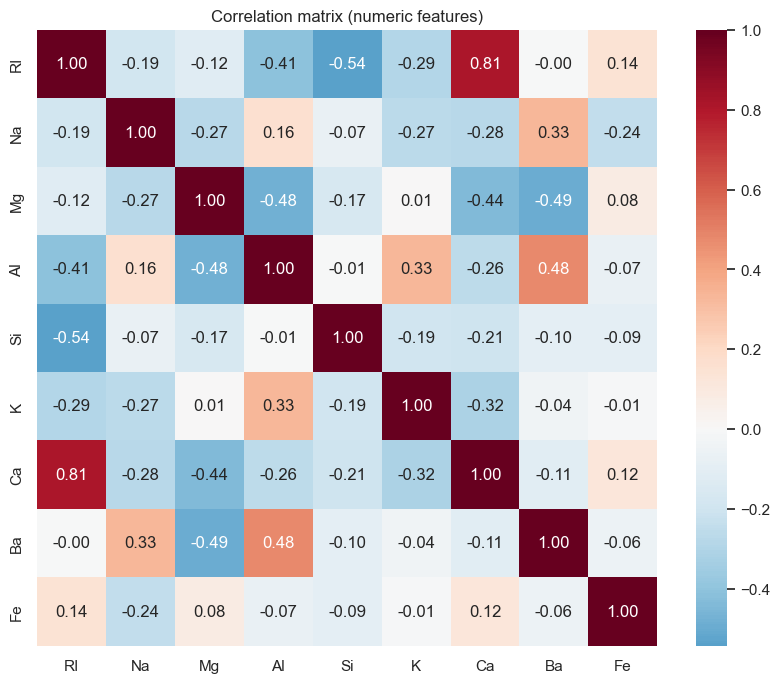

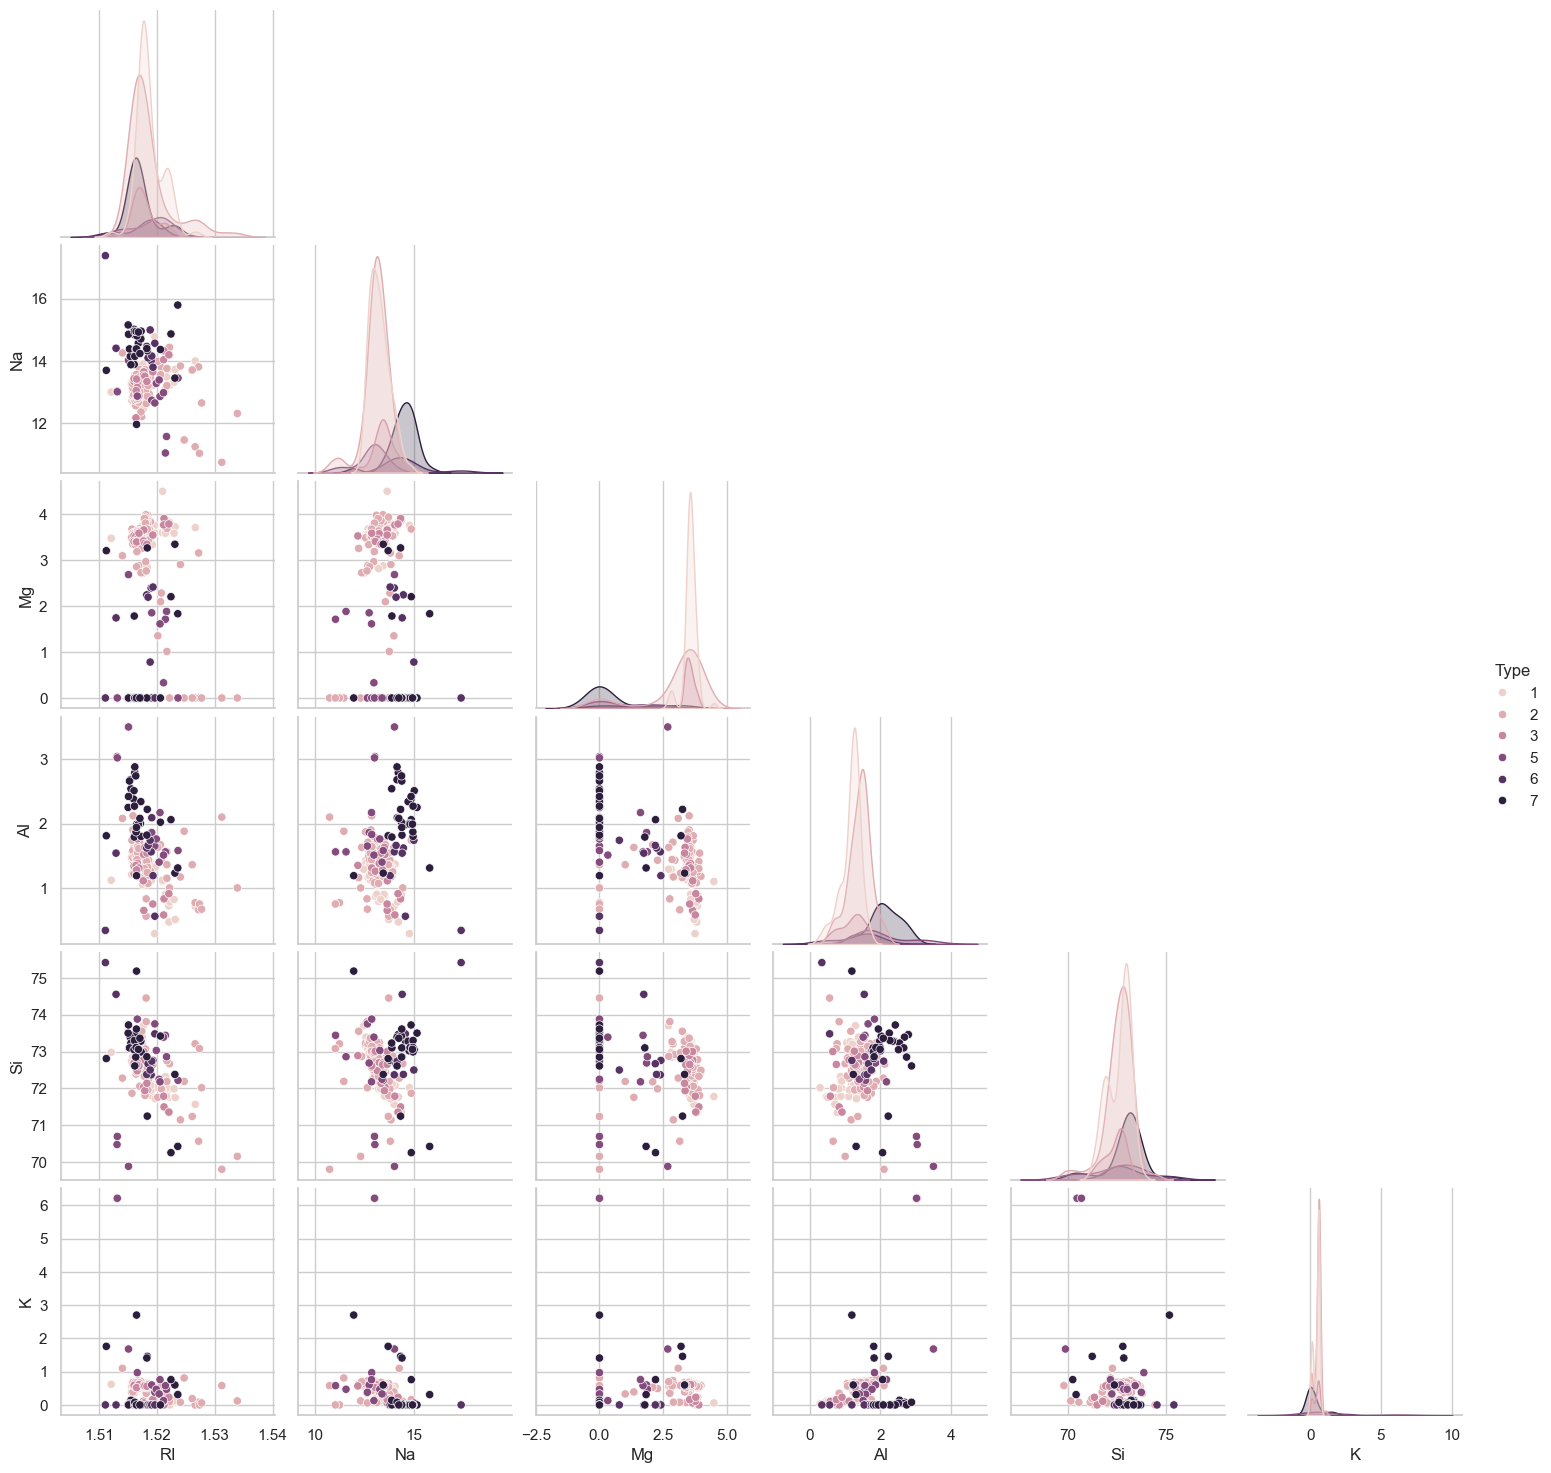

In [11]:
# Robust visualization block — 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="whitegrid")

# Detect numeric columns (attempt safe conversion of numeric-like columns)
num_cols = df.select_dtypes(include=['number']).columns.tolist()

# If there are columns that look numeric but are object dtype, try coercion
maybe_numeric = [c for c in df.columns if c not in num_cols]
for c in maybe_numeric:
    # only try coercion if most values look numeric (heuristic)
    sample = df[c].dropna().astype(str).head(100)
    if sample.str.replace(r'[-+.,0-9eE]', '', regex=True).str.strip().eq('').all():
        df[c] = pd.to_numeric(df[c], errors='coerce')
        if c not in num_cols:
            num_cols.append(c)

# Remove the target column from the num_cols list if present
if 'target_col' in globals() and target_col in num_cols:
    num_cols = [c for c in num_cols if c != target_col]

# Clean numeric columns (drop infs, but keep original df unchanged)
cleaned_num_cols = []
for c in num_cols:
    col = pd.to_numeric(df[c], errors='coerce')
    # drop if entirely NaN or constant
    if col.dropna().shape[0] >= 3 and col.nunique(dropna=True) > 1:
        cleaned_num_cols.append(c)
num_cols = cleaned_num_cols

# If no numeric columns, bail gracefully
if len(num_cols) == 0:
    print("No usable numeric columns found for visualization. Columns detected originally:", df.columns.tolist())
else:
    print(f"Numeric columns used for visualization ({len(num_cols)}): {num_cols}")

    # Histograms & boxplots
    for c in num_cols:
        fig, axes = plt.subplots(1,2, figsize=(10,2.6))
        sns.histplot(df[c].dropna(), bins=25, ax=axes[0])
        axes[0].set_title(f"Histogram: {c}")
        sns.boxplot(x=df[c].dropna(), ax=axes[1])
        axes[1].set_title(f"Boxplot: {c}")
        plt.tight_layout()
        plt.show()

    # Correlation heatmap only if at least 2 numeric columns
    if len(num_cols) >= 2:
        corr_df = df[num_cols].replace([np.inf, -np.inf], np.nan).dropna(how='all', axis=1).corr()
        if corr_df.size == 0 or corr_df.isnull().all().all():
            print("Correlation matrix is empty or all-NaN — skipping heatmap.")
        else:
            plt.figure(figsize=(10,8))
            sns.heatmap(corr_df, annot=True, fmt=".2f", cmap="RdBu_r", center=0)
            plt.title("Correlation matrix (numeric features)")
            plt.show()
    else:
        print("Not enough numeric columns to draw a correlation heatmap (need >=2).")

    # Pairplot (sampled) — only if at least 2 numeric columns and small number of columns
    try:
        if len(num_cols) >= 2:
            sample_cols = num_cols[:6]  # limit to first 6 numeric features for pairplot speed
            plot_df = df[sample_cols + ([target_col] if ('target_col' in globals() and target_col in df.columns) else [])].dropna()
            if plot_df.shape[0] > 1000:
                plot_df = plot_df.sample(1000, random_state=42)
            if plot_df.shape[0] >= 20:
                sns.pairplot(plot_df, hue=target_col if ('target_col' in globals() and target_col in plot_df.columns) else None, vars=sample_cols, corner=True)
                plt.show()
            else:
                print("Too few rows after dropping NA for a meaningful pairplot — skipping.")
        else:
            print("Not enough numeric columns to draw a pairplot (need >=2).")
    except Exception as e:
        print("Pairplot failed or is slow in this environment. Error:", e)


## 4) Data Preprocessing
Handle missing values, encode categorical variables (if any), scale features (optional), and prepare train/test split. Discuss imbalance handling.

In [12]:
# 4) Preprocessing
from sklearn.preprocessing import StandardScaler, LabelEncoder
df_proc = df.copy()

# Clean column names
df_proc.columns = [str(c).strip() for c in df_proc.columns]

# Identify target again
target = str(target_col)
y = df_proc[target]
X = df_proc.drop(columns=[target])

# Missing values strategy
print("Missing in X:", X.isnull().sum().sum())
print("Missing in y:", y.isnull().sum())

# If categorical features exist, encode them
cat_cols = X.select_dtypes(include=['object','category']).columns.tolist()
if len(cat_cols)>0:
    print("Categorical columns detected and will be one-hot encoded:", cat_cols)
    X = pd.get_dummies(X, columns=cat_cols, drop_first=True, prefix_sep='__')
else:
    print("No categorical columns detected.")

# Feature scaling (useful for distance-based or boosting sometimes, but not strictly required for RF)
scaler = StandardScaler()
num_cols = X.select_dtypes(include=['number']).columns.tolist()
X_scaled = X.copy()
if len(num_cols)>0:
    X_scaled[num_cols] = scaler.fit_transform(X_scaled[num_cols])
    print("Applied StandardScaler to numeric features.")

# Encode target to numeric if needed
if y.dtype == object or y.dtype.name == 'category':
    y_enc = LabelEncoder().fit_transform(y.astype(str))
else:
    y_enc = y.copy()

print("\nFinal feature matrix shape:", X_scaled.shape)
print("Target distribution:")
display(pd.Series(y_enc).value_counts())

Missing in X: 0
Missing in y: 0
No categorical columns detected.
Applied StandardScaler to numeric features.

Final feature matrix shape: (214, 9)
Target distribution:


Type
2    76
1    70
7    29
3    17
5    13
6     9
Name: count, dtype: int64

## 5) Random Forest Model Implementation
Split data, train a Random Forest classifier, evaluate with accuracy, precision, recall, F1-score, and show feature importances.

Train/Test shapes: (171, 9) (43, 9)

Classification report:
              precision    recall  f1-score   support

           1       0.75      0.86      0.80        14
           2       0.83      0.67      0.74        15
           3       0.67      0.67      0.67         3
           5       0.67      0.67      0.67         3
           6       0.67      1.00      0.80         2
           7       1.00      1.00      1.00         6

    accuracy                           0.79        43
   macro avg       0.76      0.81      0.78        43
weighted avg       0.80      0.79      0.79        43

Accuracy: 0.7906976744186046
F1 (macro): 0.7790123456790123


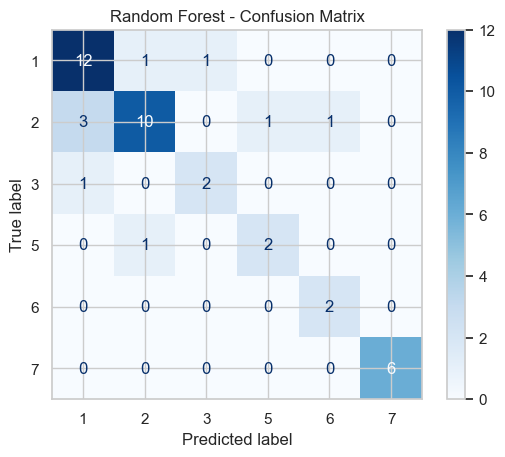

importance
Mg    0.164148
Al    0.159968
RI    0.134197
Ca    0.130109
Na    0.114020
Si    0.089553
Ba    0.084962
K     0.081563
Fe    0.041481

In [13]:
# 5) Random Forest training and evaluation
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_enc, test_size=0.2, random_state=42, stratify=y_enc)

print("Train/Test shapes:", X_train.shape, X_test.shape)
rf = RandomForestClassifier(n_estimators=200, random_state=42, n_jobs=-1)
rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)

print("\nClassification report:")
print(classification_report(y_test, y_pred, zero_division=0))
print("Accuracy:", accuracy_score(y_test, y_pred))
print("F1 (macro):", f1_score(y_test, y_pred, average='macro', zero_division=0))

# Confusion matrix
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay
disp = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix(y_test, y_pred), display_labels=rf.classes_)
disp.plot(cmap='Blues', values_format='d')
plt.title("Random Forest - Confusion Matrix")
plt.show()

# Feature importances
import pandas as pd
feat_imp = pd.Series(rf.feature_importances_, index=X_scaled.columns).sort_values(ascending=False)
display(feat_imp.head(20).to_frame('importance'))

## 6) Bagging and Boosting Methods
Implement Bagging (BaggingClassifier) and Boosting (AdaBoost and GradientBoosting), compare performance with Random Forest.

In [14]:
# 6) Bagging and Boosting comparisons
from sklearn.ensemble import BaggingClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.metrics import classification_report, accuracy_score, f1_score

models = {
    'RandomForest': RandomForestClassifier(n_estimators=200, random_state=42, n_jobs=-1),
    'Bagging': BaggingClassifier(n_estimators=200, random_state=42, n_jobs=-1),
    'AdaBoost': AdaBoostClassifier(n_estimators=200, random_state=42),
    'GradientBoosting': GradientBoostingClassifier(n_estimators=200, random_state=42)
}

results = {}
for name, model in models.items():
    model.fit(X_train, y_train)
    yp = model.predict(X_test)
    results[name] = {
        'accuracy': accuracy_score(y_test, yp),
        'f1_macro': f1_score(y_test, yp, average='macro', zero_division=0)
    }
    print(f"\nModel: {name}")
    print(classification_report(y_test, yp, zero_division=0))

# Summary table
import pandas as pd
res_df = pd.DataFrame(results).T
display(res_df.sort_values(by='f1_macro', ascending=False))


Model: RandomForest
              precision    recall  f1-score   support

           1       0.75      0.86      0.80        14
           2       0.83      0.67      0.74        15
           3       0.67      0.67      0.67         3
           5       0.67      0.67      0.67         3
           6       0.67      1.00      0.80         2
           7       1.00      1.00      1.00         6

    accuracy                           0.79        43
   macro avg       0.76      0.81      0.78        43
weighted avg       0.80      0.79      0.79        43


Model: Bagging
              precision    recall  f1-score   support

           1       0.71      0.71      0.71        14
           2       0.77      0.67      0.71        15
           3       0.67      0.67      0.67         3
           5       0.67      0.67      0.67         3
           6       0.67      1.00      0.80         2
           7       0.86      1.00      0.92         6

    accuracy                           0

accuracy  f1_macro
RandomForest      0.790698  0.779012
Bagging           0.744186  0.747497
GradientBoosting  0.744186  0.747009
AdaBoost          0.465116  0.435128

## 7) Handling Imbalance
Discuss and demonstrate SMOTE oversampling on the training set (only if imbalance exists).

In [15]:
# 7) Handling imbalance (SMOTE)
try:
    from imblearn.over_sampling import SMOTE
    print("Original training distribution:")
    display(pd.Series(y_train).value_counts())
    sm = SMOTE(random_state=42)
    X_res, y_res = sm.fit_resample(X_train, y_train)
    print("Resampled distribution:")
    display(pd.Series(y_res).value_counts())
    # Train RF on resampled data
    rf_sm = RandomForestClassifier(n_estimators=200, random_state=42, n_jobs=-1)
    rf_sm.fit(X_res, y_res)
    y_pred_sm = rf_sm.predict(X_test)
    print("\nClassification report (RF trained on SMOTE):")
    print(classification_report(y_test, y_pred_sm, zero_division=0))
except Exception as e:
    print("SMOTE not available or failed:", e)

Original training distribution:


Type
2    61
1    56
7    23
3    14
5    10
6     7
Name: count, dtype: int64

Resampled distribution:


Type
7    61
1    61
2    61
3    61
6    61
5    61
Name: count, dtype: int64


Classification report (RF trained on SMOTE):
              precision    recall  f1-score   support

           1       0.83      0.71      0.77        14
           2       0.77      0.67      0.71        15
           3       0.33      0.67      0.44         3
           5       0.75      1.00      0.86         3
           6       0.67      1.00      0.80         2
           7       1.00      0.83      0.91         6

    accuracy                           0.74        43
   macro avg       0.73      0.81      0.75        43
weighted avg       0.79      0.74      0.75        43



## 8) Discussion: Bagging vs Boosting and Imbalance Strategies

**Bagging (Bootstrap Aggregating):** trains multiple base learners independently on bootstrap samples and aggregates predictions (e.g., Random Forest). Reduces variance.

**Boosting:** trains learners sequentially where each learner tries to correct errors of the previous. Boosting reduces bias and can improve accuracy but may overfit; examples include AdaBoost and Gradient Boosting.

**Handling imbalance:** Use class weights, resampling (oversample minority: SMOTE, ADASYN), undersample majority, or use metrics and algorithms robust to imbalance. Ensemble methods + balanced class weights often help.


In [16]:
# 9) Save outputs to local folder
import os, joblib
os.makedirs(r"D:\DATA-SCIENCE\ASSIGNMENTS\14 random forest", exist_ok=True)
# Save models and processed data if available
try:
    rf_path = os.path.join(r"D:\DATA-SCIENCE\ASSIGNMENTS\14 random forest", "rf_model.joblib")
    joblib.dump(rf, rf_path)
    print("Saved RandomForest model to:", rf_path)
except Exception as e:
    print("Could not save RF model:", e)

try:
    X_scaled.to_csv(os.path.join(r"D:\DATA-SCIENCE\ASSIGNMENTS\14 random forest", "glass_processed_X.csv"), index=False)
    pd.Series(y_enc).to_csv(os.path.join(r"D:\DATA-SCIENCE\ASSIGNMENTS\14 random forest", "glass_processed_y.csv"), index=False)
    print("Saved processed data to folder:", r"D:\DATA-SCIENCE\ASSIGNMENTS\14 random forest")
except Exception as e:
    print("Could not save processed data:", e)

Saved RandomForest model to: D:\DATA-SCIENCE\ASSIGNMENTS\14 random forest\rf_model.joblib
Saved processed data to folder: D:\DATA-SCIENCE\ASSIGNMENTS\14 random forest
